In [1]:
# Import libraries
import numpy as np
import math
import random
import pandas as pd
import anndata
import scanpy.external as sce  # for harmony_integrate
import harmonypy
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm # linear regression
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scanpy as sc
import os
import SpatialproxseqClasses as SPC

#*****
mpl.rcdefaults()
# Set font to be arial
mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' 
mpl.rcParams['axes.titlesize'] = 12
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'

#to store text as text, not as path
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
#*****
# Seed number
np.random.seed(2025)
random.seed(2025)

In [2]:
def load_and_preprocess_sample(visium_path, cluster_csv, sample_name):
    # Load Visium data
    adata = sc.read_visium(visium_path)
    adata.var_names_make_unique()

    # Annotate RNA
    adata.obs["mRNA"] = "RNA"

    # Mitochondrial gene QC
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

    # Optional mitochondrial filtering
    # adata = adata[adata.obs["pct_counts_mt"] < 6].copy()

    # UMI filtering
    sc.pp.filter_cells(adata, min_counts=1000)
    sc.pp.filter_genes(adata, min_cells=3)

  # Preserve counts
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata.copy()
    sc.pp.highly_variable_genes(adata, n_top_genes=4000, )
    adata = adata[:, adata.var["highly_variable"]].copy()
    sc.pp.scale(adata, max_value=10) 

    # Load external cluster annotation
    cluster_info = pd.read_csv(cluster_csv, index_col=0)
    adata.obs = adata.obs.join(cluster_info)

    # Subset to GC zones
    adata = adata[adata.obs["mrna_annotation"].isin(["Light zone", "Dark zone", ])].copy()

    # Add sample ID for batch correction
    adata.obs["batch"] = sample_name

    return adata


In [3]:
adata_A1 = load_and_preprocess_sample("A1_outs", "A1_adata_mRNA_cell_clusters.csv", "A1")
adata_B1 = load_and_preprocess_sample("B1_outs", "B1_adata_mRNA_cell_clusters.csv", "B1")
adata_D1 = load_and_preprocess_sample("D1_outs", "D1_adata_mRNA_cell_clusters.csv", "D1")


/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_19624/3645838122.py:3: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(visium_path)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_19624/3645838122.py:3: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(visium_p

In [4]:

# Add library_id
adata_A1.obs["library_id"] = "A1"
adata_B1.obs["library_id"] = "B1"
adata_D1.obs["library_id"] = "D1"

adata_A1.obs_names = ["A1_" + name for name in adata_A1.obs_names]
adata_B1.obs_names = ["B1_" + name for name in adata_B1.obs_names]
adata_D1.obs_names = ["D1_" + name for name in adata_D1.obs_names]


# Concatenate
adata = anndata.concat(
    [adata_A1, adata_B1, adata_D1],
    label="batch", keys=["A1", "B1", "D1"],
    index_unique=None
)

# Define function to extract spatial key name
def get_spatial_key(adata):
    return list(adata.uns["spatial"].keys())[0]

# Fix spatial images
adata.uns["spatial"] = {
    "A1": adata_A1.uns["spatial"][get_spatial_key(adata_A1)],
    "B1": adata_B1.uns["spatial"][get_spatial_key(adata_B1)],
    "D1": adata_D1.uns["spatial"][get_spatial_key(adata_D1)],
}


In [5]:
adata.write("combined_LZ_DZ_mRNA_ABD.h5ad")

In [6]:

# Step 3: PCA
sc.tl.pca(adata, svd_solver='arpack')

# Step 4: Harmony integration to remove batch effect
sce.pp.harmony_integrate(adata, key='batch')

# Step 5: Neighbors & UMAP using Harmony-corrected PCA
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

adata.write("combined_LZ_DZ_mRNA_ABD_remove_batch_effect.h5ad")

# Step 6: Clustering (optional)
sc.tl.leiden(adata, resolution=0.5)

sc.set_figure_params(figsize=(4, 4))

2025-08-14 08:53:41,745 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-14 08:53:42,713 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-14 08:53:42,741 - harmonypy - INFO - Iteration 1 of 10
2025-08-14 08:53:43,386 - harmonypy - INFO - Iteration 2 of 10
2025-08-14 08:53:44,106 - harmonypy - INFO - Iteration 3 of 10
2025-08-14 08:53:44,677 - harmonypy - INFO - Iteration 4 of 10
2025-08-14 08:53:45,240 - harmonypy - INFO - Iteration 5 of 10
2025-08-14 08:53:45,632 - harmonypy - INFO - Iteration 6 of 10
2025-08-14 08:53:45,990 - harmonypy - INFO - Iteration 7 of 10
2025-08-14 08:53:46,332 - harmonypy - INFO - Iteration 8 of 10
2025-08-14 08:53:46,605 - harmonypy - INFO - Iteration 9 of 10
2025-08-14 08:53:47,054 - harmonypy - INFO - Iteration 10 of 10
2025-08-14 08:53:47,337 - harmonypy - INFO - Converged after 10 iterations
/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_19624/2691408738.py:14: FutureWarning: In the future, 

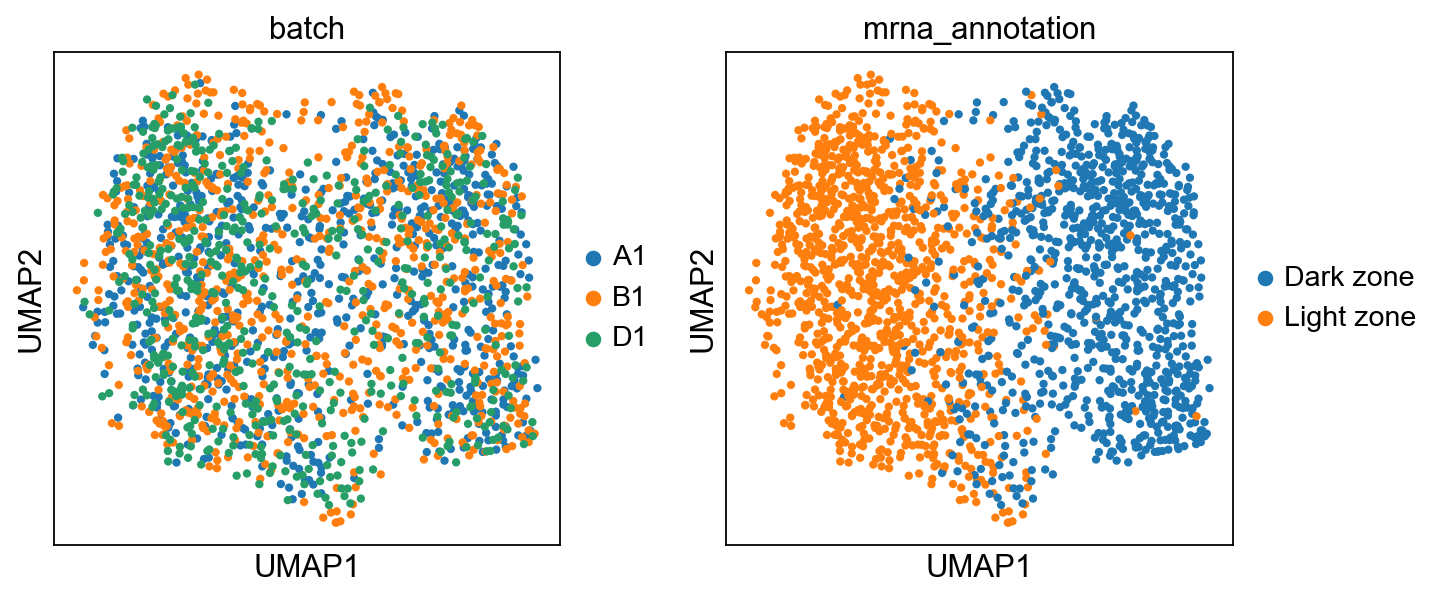

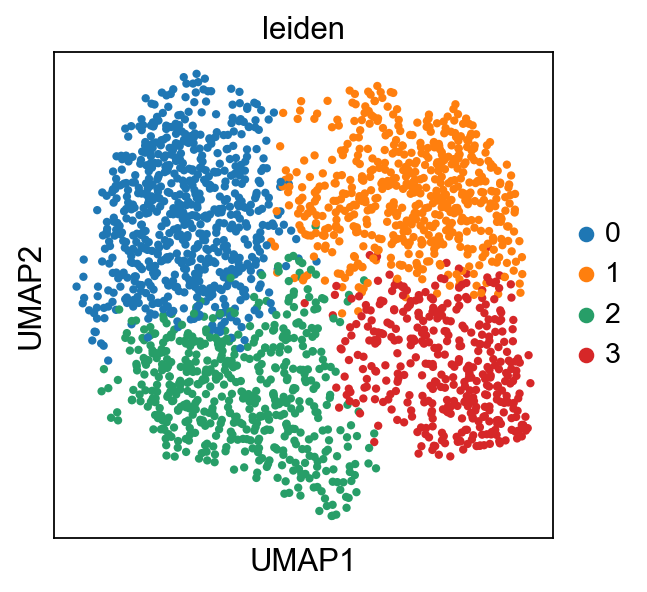

In [7]:
# Step 7: Plot (optional)
sc.pl.umap(adata, color=["batch", "mrna_annotation", ])
sc.pl.umap(adata, color=["leiden"])

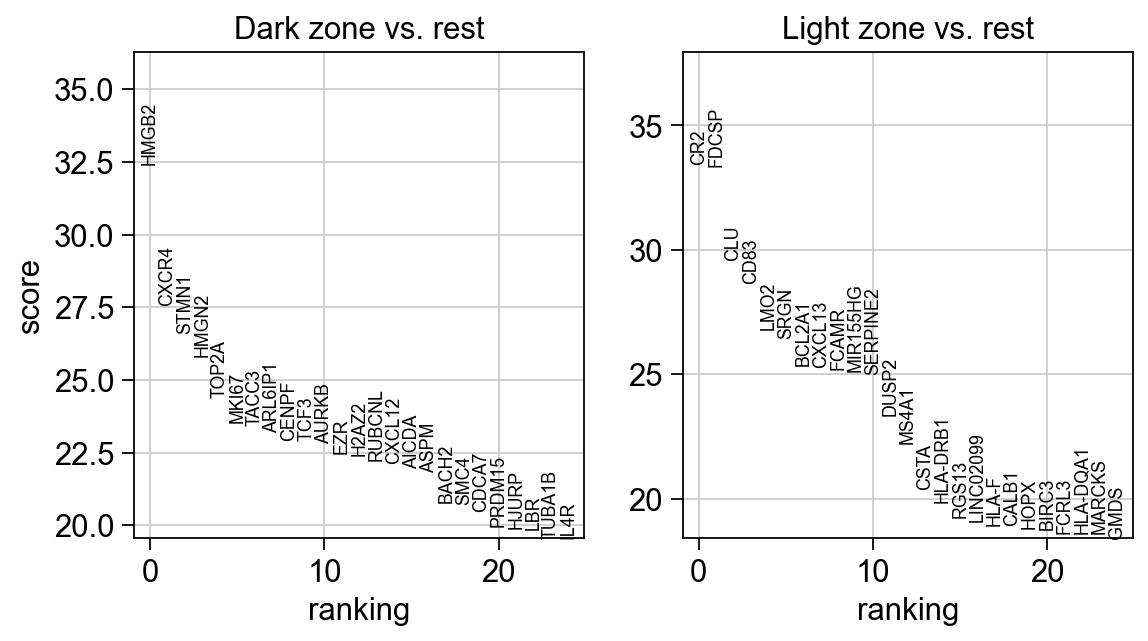

In [8]:
sc.tl.rank_genes_groups(adata, groupby="mrna_annotation", method="wilcoxon", )
sc.pl.rank_genes_groups(adata, groupby="mrna_annotation", n_genes=25, sharey=False)

In [9]:
# Function to set spatial image and scalefactor metadata
def set_uns_parameters(adata, library_id, image, scalefactors):
    spatial_key = "spatial"
    adata.uns[spatial_key] = {
        library_id: {
            "images": {"hires": image},
            "scalefactors": scalefactors
        }
    }

# Sample metadata for all four samples
samples = {
    "A1": {
        "matrix": "A1-PLA_count_matrix.txt.gz",
        "barcode": "A1_outs/spatial/tissue_positions.csv",
        "image": "A1_outs/spatial/tissue_hires_image.png",
        "scalefactors": {'tissue_hires_scalef': 0.5177323,
                         'tissue_lowres_scalef': 0.1553197,
                         'fiducial_diameter_fullres': 45.467644,
                         'spot_diameter_fullres': 28.146637

        }
    },
    "B1": {
        "matrix": "B1-PLA_count_matrix.txt.gz",
        "barcode": "B1_outs/spatial/tissue_positions.csv",
        "image": "B1_outs/spatial/tissue_hires_image.png",
        "scalefactors": {
            'tissue_hires_scalef': 0.53748995,
            'tissue_lowres_scalef': 0.16124697,
            'fiducial_diameter_fullres': 45.46590400000001,
            'spot_diameter_fullres': 28.145561000000004
        }
    },

    "D1": {
        "matrix": "D1-PLA_count_matrix.txt.gz",
        "barcode": "D1_outs/spatial/tissue_positions.csv",
        "image": "D1_outs/spatial/tissue_hires_image.png",
        "scalefactors": {
            'tissue_hires_scalef': 0.53590566,
            'tissue_lowres_scalef': 0.1607717,
            'fiducial_diameter_fullres': 45.420517,
            'spot_diameter_fullres': 28.117462
        }
    }
}
# Output dictionaries
adata_pla_dict = {}
adata_protein_dict = {}
adata_protein_pair_dict = {}


# Loop over samples
for sid, info in samples.items():
    print(f"Processing sample: {sid}")

    # Load raw data
    data = pd.read_csv(info["matrix"], sep="\t", index_col=0)

    # Fix probe names
    data.index = data.index.str.replace(r"^VCAM1_B:(.*)$", r"CD40_A:\1", regex=True)
    data.index = data.index.str.replace(r"^CD29_B:(.*)$", r"CD279_A:\1", regex=True)
    data.index = data.index.str.replace(r"^LFA1_B:(.*)$", r"CD11a_A:\1", regex=True)

    # Filter & clean PLA
    valid_condition = ~data.index.str.contains(r'((:.*_A)|(_B:))', regex=True)
    pla = data[valid_condition]
    pla.index = pla.index.str.replace(r'(_A|_B)', '', regex=True)
    pla = pla.loc[~pla.index.str.contains("HLADPRQ"), :]

    # Build PLA object  
    pla_obj = SPC.sproxseqObject(pla)
    pla_obj.compute_protein_pair_counts()
    pla_obj.compute_protein_abundance()

  # Load spatial info
    tissue_barcode = pd.read_csv(info["barcode"]).set_index("barcode")
    tissue_barcode = tissue_barcode.loc[pla.transpose().index, :]
    spatial = tissue_barcode[["pxl_col_in_fullres", "pxl_row_in_fullres"]].to_numpy()
    obs = tissue_barcode[["in_tissue", "array_row", "array_col"]]

    # Create AnnData objects
    adata_pla = sc.AnnData(pla.transpose().to_numpy(), obsm={"spatial": spatial}, obs=obs.copy())
    adata_protein = sc.AnnData(pla_obj.protein_count.transpose().to_numpy(), obsm={"spatial": spatial}, obs=obs.copy())
    adata_protein_pair = sc.AnnData(pla_obj.protein_pair_count.transpose().to_numpy(), obsm={"spatial": spatial}, obs=obs.copy())
 
    # Add batch
    for ad in [adata_pla, adata_protein, adata_protein_pair, ]:
        ad.obs["batch"] = sid

    # Assign var names
    adata_pla.var.index = pla.index
    adata_protein.var.index = pla_obj.protein_count.index
    adata_protein_pair.var.index = pla_obj.protein_pair_count.index


    # Set spatial metadata
    image = mpimg.imread(info["image"])
    library_id = f"{sid}_Human_tonsil_Proxseq"
    for ad in [adata_pla, adata_protein, adata_protein_pair, ]:
        set_uns_parameters(ad, library_id, image, info["scalefactors"])

    # Normalize & log
    for ad, tag, ftype in zip([adata_protein, adata_protein_pair], ["protein", "protein_pair"], ["protein", "protein_pair"]):
        ad.var["IgG"] = ad.var_names.str.contains("IgG1a")
        ad.var["feature_types"] = ftype
        ad.layers["counts"] = ad.X.copy()
        sc.pp.normalize_total(ad, target_sum=1e4)
        sc.pp.log1p(ad)
        ad.raw = ad.copy()
        sc.pp.scale(ad, max_value=10) 

    # 👉 Load cluster info HERE
    cluster_csv = f"{sid}_adata_mRNA_cell_clusters.csv"  # you provide this file
    cluster_info = pd.read_csv(cluster_csv, index_col=0)

    # 👉 Join and subset for protein and protein_pair
    for ad in [adata_protein, adata_protein_pair]:
        ad.obs = ad.obs.join(cluster_info)
        ad._inplace_subset_obs(ad.obs["mrna_annotation"].isin(["Light zone", "Dark zone", ]))

    # Save
    adata_pla_dict[sid] = adata_pla
    adata_protein_dict[sid] = adata_protein
    adata_protein_pair_dict[sid] = adata_protein_pair

print("✅ All samples loaded & subset to LZ/DZ successfully.")


Processing sample: A1


/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_19624/1696771801.py:67: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  valid_condition = ~data.index.str.contains(r'((:.*_A)|(_B:))', regex=True)


Processing sample: B1


/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_19624/1696771801.py:67: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  valid_condition = ~data.index.str.contains(r'((:.*_A)|(_B:))', regex=True)


Processing sample: D1


/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_19624/1696771801.py:67: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  valid_condition = ~data.index.str.contains(r'((:.*_A)|(_B:))', regex=True)


✅ All samples loaded & subset to LZ/DZ successfully.


In [10]:

adata_protein_A1 = adata_protein_dict["A1"]
adata_protein_B1 = adata_protein_dict["B1"]
adata_protein_D1 = adata_protein_dict["D1"]

# Add library_id
adata_protein_A1.obs["library_id"] = "A1"
adata_protein_B1.obs["library_id"] = "B1"
adata_protein_D1.obs["library_id"] = "D1"

adata_protein_A1.obs_names = ["A1_" + name for name in adata_protein_A1.obs_names]
adata_protein_B1.obs_names = ["B1_" + name for name in adata_protein_B1.obs_names]
adata_protein_D1.obs_names = ["D1_" + name for name in adata_protein_D1.obs_names]


# Concatenate
adata_protein_all = anndata.concat(
    [adata_protein_A1, adata_protein_B1, adata_protein_D1],
    label="batch", keys=["A1", "B1", "D1"],
    index_unique=None
)

# Define function to extract spatial key name
def get_spatial_key(adata_protein_all):
    return list(adata_protein_all.uns["spatial"].keys())[0]

# Fix spatial images
adata_protein_all.uns["spatial"] = {
    "A1": adata_protein_A1.uns["spatial"][get_spatial_key(adata_protein_A1)],
    "B1": adata_protein_B1.uns["spatial"][get_spatial_key(adata_protein_B1)],
    "D1": adata_protein_D1.uns["spatial"][get_spatial_key(adata_protein_D1)],
}


In [11]:
adata_protein_all.write("combined_LZ_DZ_protein_ABD.h5ad")


In [12]:
# Step 3: Scaling and PCA
sc.tl.pca(adata_protein_all, svd_solver='arpack')

# Step 4: Harmony integration to remove batch effect
sce.pp.harmony_integrate(adata_protein_all, key='batch')

# Step 5: Neighbors & UMAP
sc.pp.neighbors(adata_protein_all, use_rep='X_pca_harmony', n_neighbors=10, n_pcs=30)
sc.tl.umap(adata_protein_all)
adata_protein_all.write("combined_LZ_DZ_protein_ABD_remove_batch_effect.h5ad")


# Step 6: Clustering
sc.tl.leiden(adata_protein_all, resolution=0.5)



2025-08-14 08:53:54,499 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-14 08:53:55,277 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-14 08:53:55,305 - harmonypy - INFO - Iteration 1 of 10
2025-08-14 08:53:55,785 - harmonypy - INFO - Iteration 2 of 10
2025-08-14 08:53:56,302 - harmonypy - INFO - Iteration 3 of 10
2025-08-14 08:53:56,739 - harmonypy - INFO - Iteration 4 of 10
2025-08-14 08:53:57,213 - harmonypy - INFO - Iteration 5 of 10
2025-08-14 08:53:57,661 - harmonypy - INFO - Iteration 6 of 10
2025-08-14 08:53:58,201 - harmonypy - INFO - Iteration 7 of 10
2025-08-14 08:53:58,671 - harmonypy - INFO - Iteration 8 of 10
2025-08-14 08:53:58,989 - harmonypy - INFO - Iteration 9 of 10
2025-08-14 08:53:59,518 - harmonypy - INFO - Iteration 10 of 10
2025-08-14 08:53:59,939 - harmonypy - INFO - Stopped before convergence


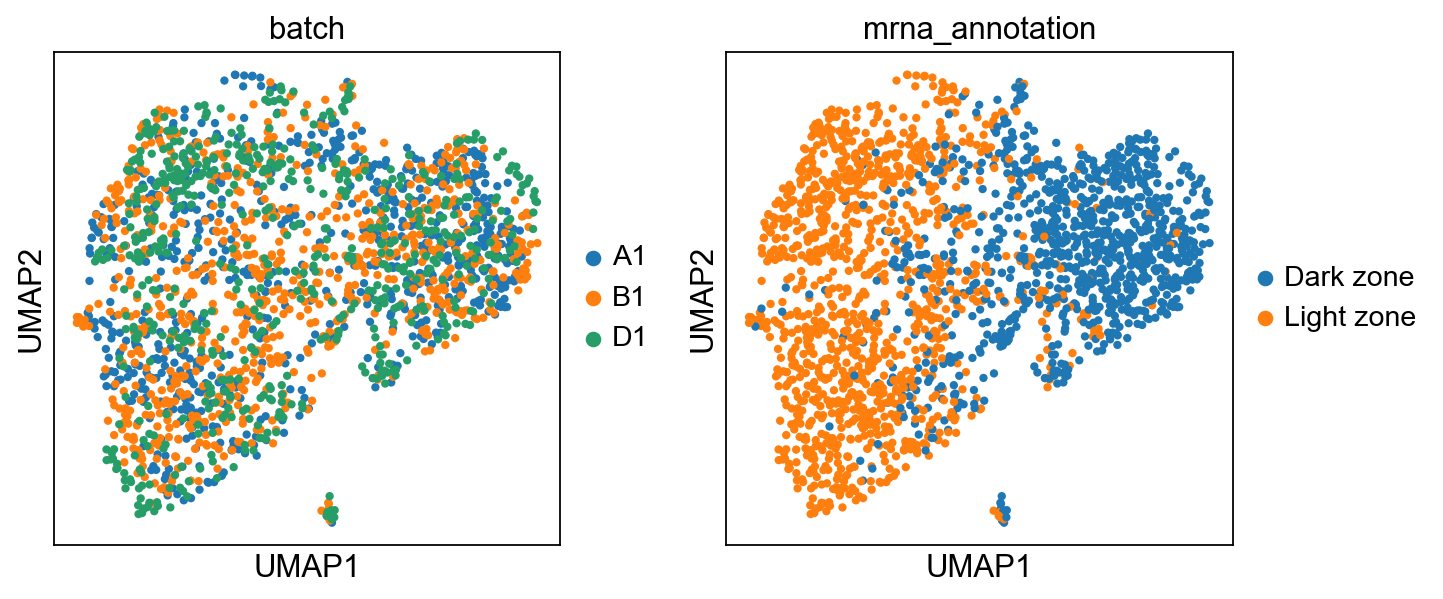

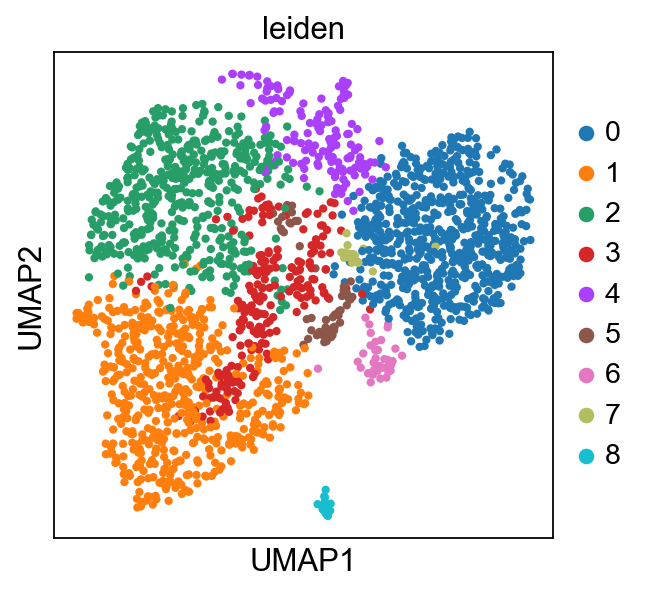

In [13]:
# Step 7: Visualization
sc.pl.umap(adata_protein_all, color=["batch", "mrna_annotation", ],)
sc.pl.umap(adata_protein_all, color=["leiden"],)

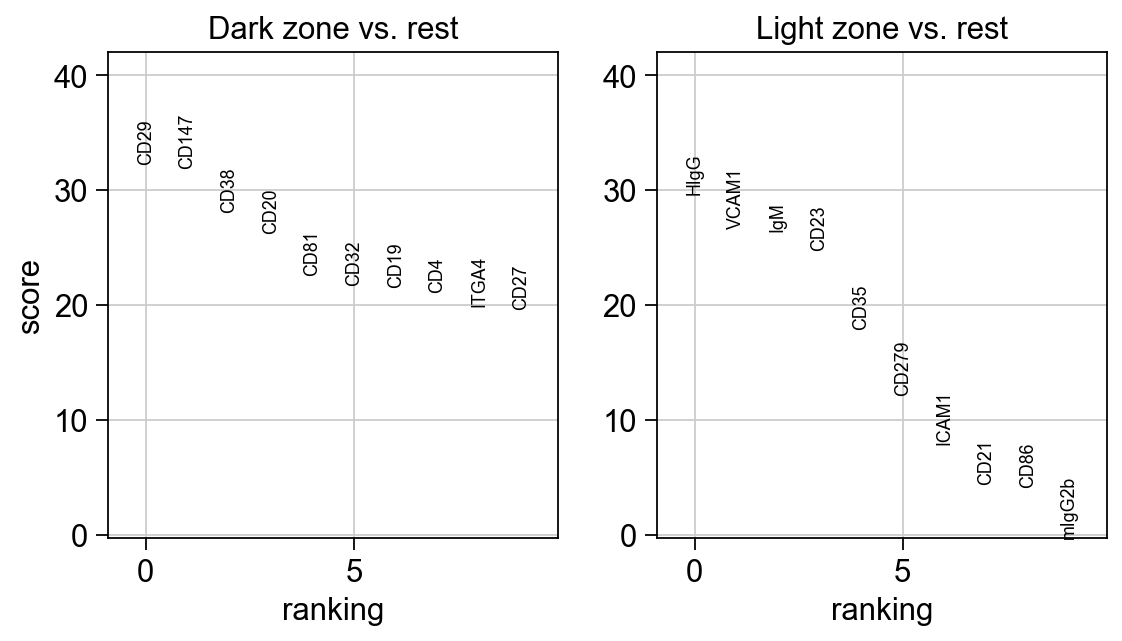

In [14]:
sc.tl.rank_genes_groups(adata_protein_all, groupby='mrna_annotation', method='wilcoxon')
sc.pl.rank_genes_groups(adata_protein_all, n_genes=10)

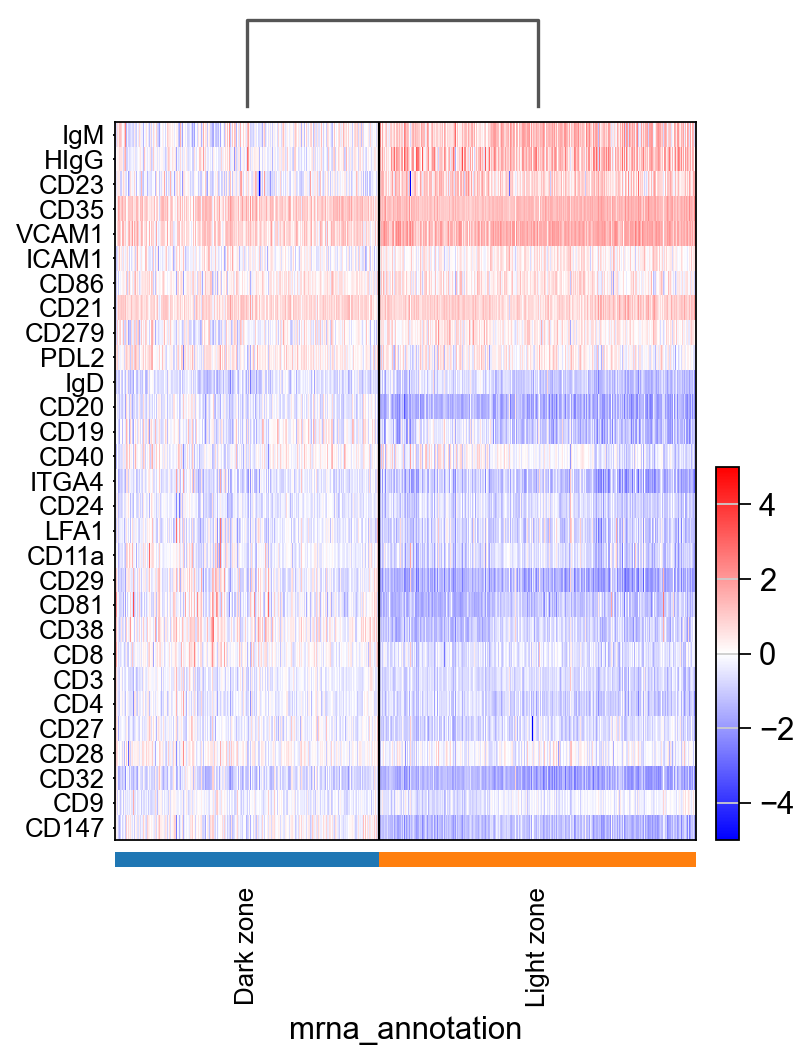

In [15]:
custom_protein_order = [  'IgM','HIgG','CD23', 'CD35', 'VCAM1','ICAM1', 'CD86', 'CD21',  'CD279','PDL2','IgD', 'CD20', 'CD19',  'CD40', 'ITGA4', 'CD24', 'LFA1','CD11a',
    'CD29','CD81','CD38', 'CD8',  'CD3',  'CD4','CD27','CD28', 'CD32','CD9', 'CD147',]

sc.pl.rank_genes_groups_heatmap(adata_protein_all,var_names=custom_protein_order, groupby='mrna_annotation', swap_axes=True, use_raw=False, vmin = -5, vmax = 5,
                                cmap='bwr', figsize=(5, 7))

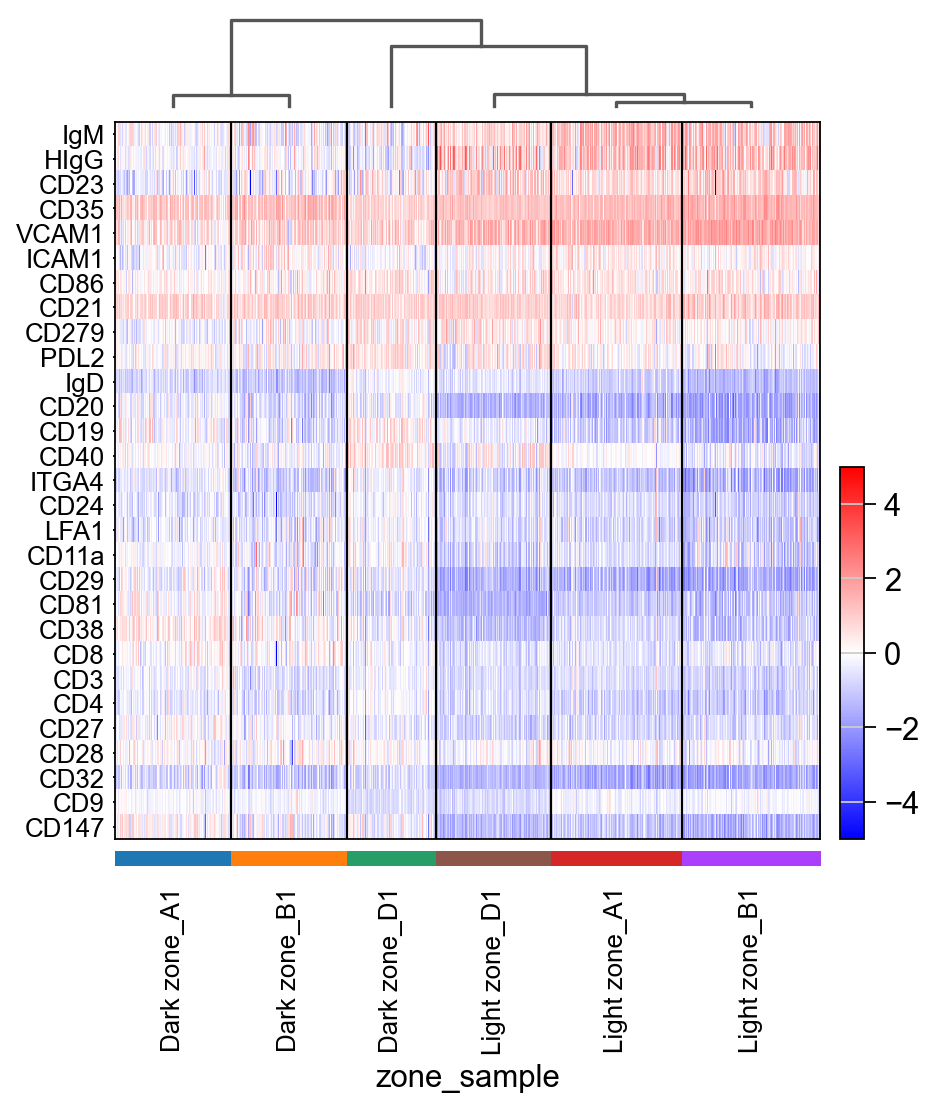

In [16]:
# Step 1: Combine zone and batch/sample information into one label
adata_protein_all.obs["zone_sample"] = (
    adata_protein_all.obs["mrna_annotation"].astype(str) + "_" + 
    adata_protein_all.obs["batch"].astype(str)
)

# Step 2: Plot the heatmap with the combined annotation
sc.pl.rank_genes_groups_heatmap(
    adata_protein_all,
    var_names=custom_protein_order,       # your predefined list of proteins
    groupby="zone_sample",                # combined zone and batch info
    swap_axes=True,                       # so genes are on y-axis
    use_raw=False,
    vmin=-5, vmax=5,
    cmap="bwr",
    figsize=(6, 7)
)


In [17]:
adata_rna_gc_follicle = sc.read("combined_LZ_DZ_mRNA_ABD_remove_batch_effect.h5ad")
adata_protein_gc_follicle = sc.read("combined_LZ_DZ_protein_ABD_remove_batch_effect.h5ad")

In [18]:
adata_rna_gc_follicle.obs['zone_sample'] = adata_rna_gc_follicle.obs['mrna_annotation'].astype(str) + '_' + adata_rna_gc_follicle.obs['batch'].astype(str)

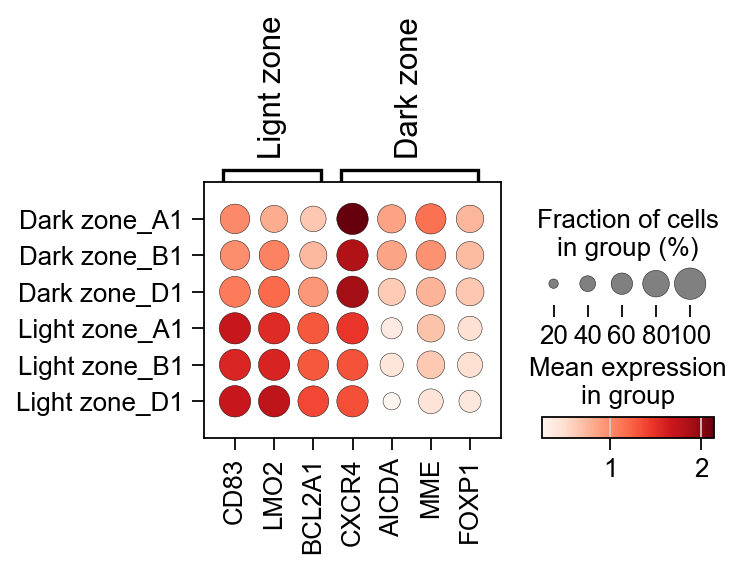

In [19]:
marker_genes_dict = {
    'Lignt zone': ['CD83', 'LMO2', 'BCL2A1'],
    'Dark zone' : ['CXCR4', 'AICDA', 'MME', 'FOXP1']
}
sc.pl.dotplot(adata_rna_gc_follicle, marker_genes_dict, "zone_sample",use_raw = True, dendrogram=False, save="Extended-Fig-7a.svg")


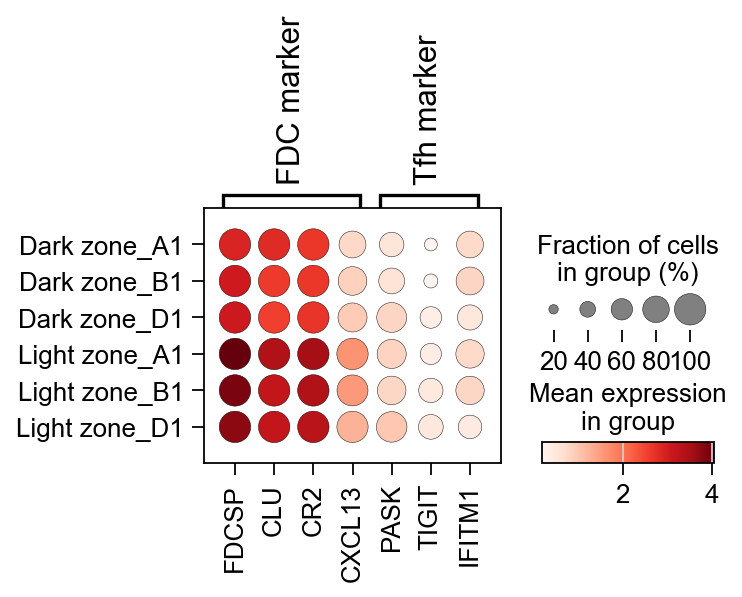

In [20]:
marker_genes_dict = {
    'FDC marker': ['FDCSP','CLU','CR2','CXCL13'],
    'Tfh marker' : ['PASK','TIGIT','IFITM1']
}
sc.pl.dotplot(adata_rna_gc_follicle, marker_genes_dict, "zone_sample",use_raw = True, dendrogram=False, save="Extended-Fig-7b.svg")


In [21]:
adata_protein_gc_follicle.obs['zone_sample'] = adata_protein_gc_follicle.obs['mrna_annotation'].astype(str) + '_' + adata_protein_gc_follicle.obs['batch'].astype(str)

In [22]:
custom_protein_order = [ 'CD35', 'VCAM1',  'IgM','HIgG', 'CD86','PDL2', 'CD21', 'CD23', 'IgD', 'CD20', 'CD19',  'CD40', 'ITGA4', 'CD24', 'LFA1','CD11a',
    'CD29','CD81','CD38', 'CD8',  'CD3',  'CD4','CD27','CD279','CD28', 'CD32','CD9', 'CD147','ICAM1',]

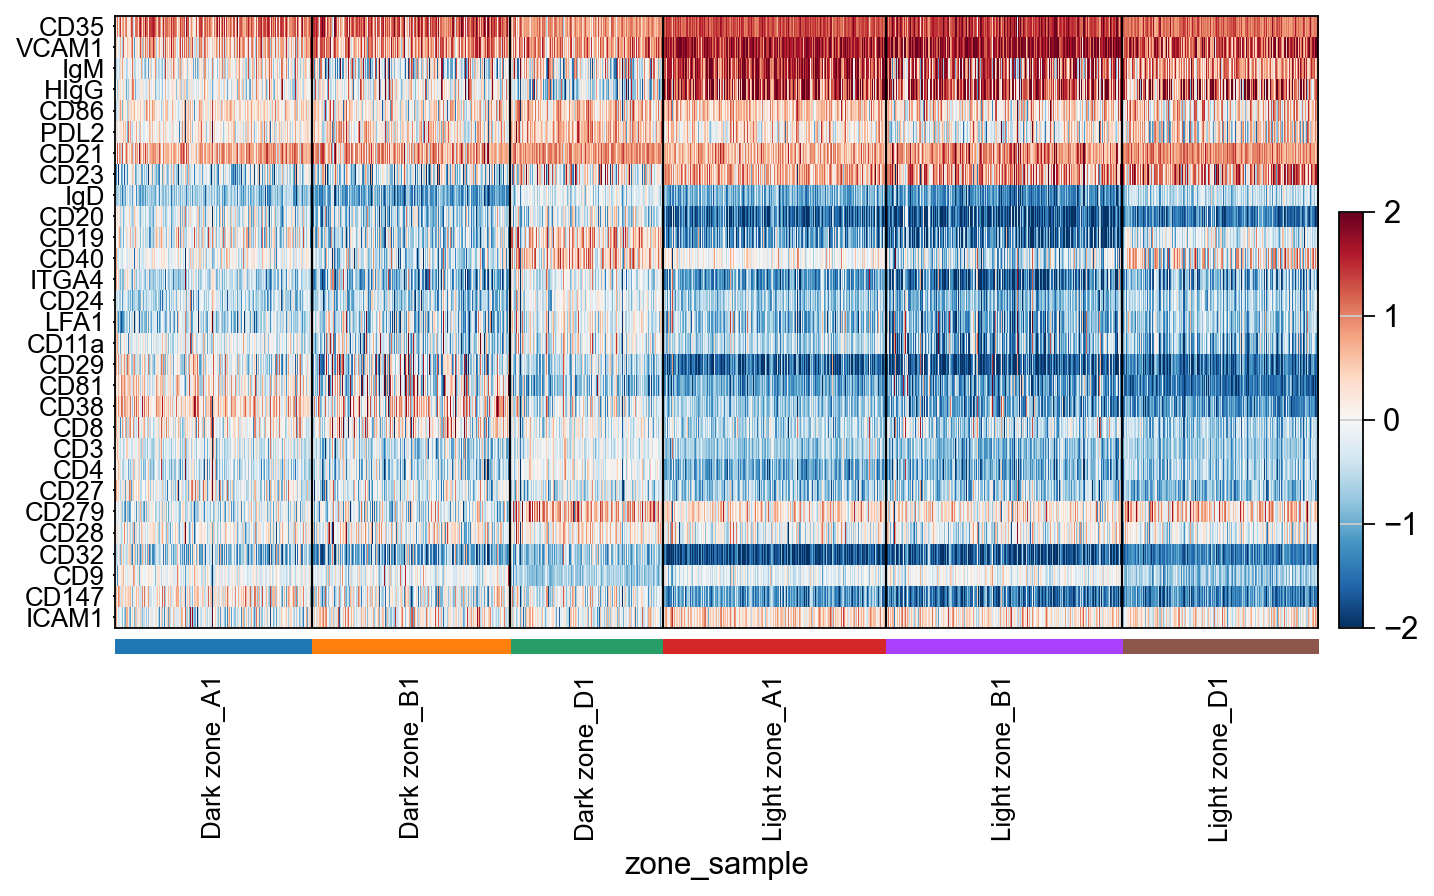

In [23]:
sc.pl.heatmap(adata_protein_gc_follicle, custom_protein_order, "zone_sample", use_raw=False, vmin = -2, vmax =2, dendrogram=False, swap_axes=True, cmap='RdBu_r')

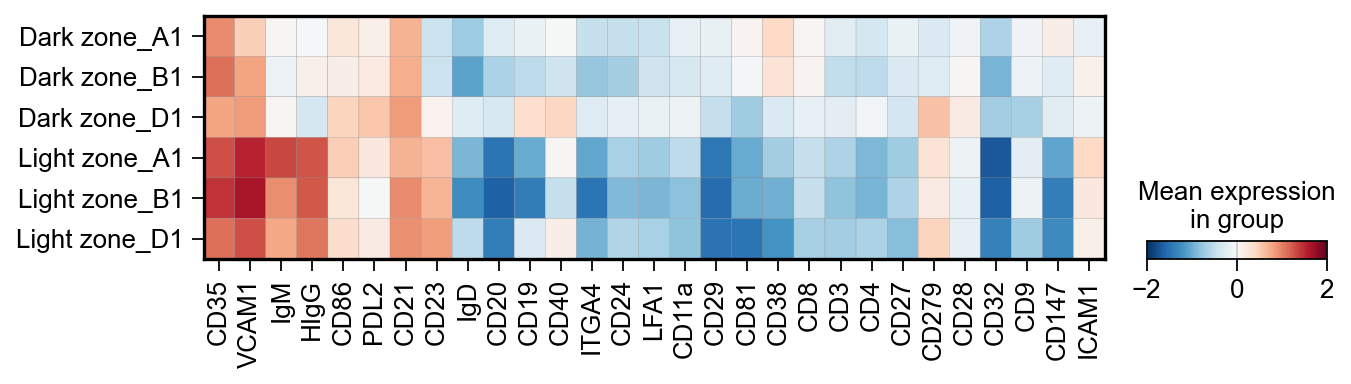

In [24]:
sc.pl.matrixplot(
    adata_protein_gc_follicle,
    var_names=custom_protein_order,
    groupby="zone_sample",
    use_raw=False,
    vmin=-2,
    vmax=2,
    cmap='RdBu_r',
    figsize=(9, 2),
    # swap_axes=True
)

In [25]:
import pandas as pd
from scipy.stats import ttest_ind

# List to store t-test results from each sample
significance_results = []

# Loop through all batches (samples)
for batch in ['A1', 'B1', 'D1']:
    adata_sample = adata_protein_gc_follicle[adata_protein_gc_follicle.obs['batch'] == batch]

    # Define masks for Light Zone and Dark Zone
    light_mask = adata_sample.obs['mrna_annotation'] == 'Light zone'
    dark_mask = adata_sample.obs['mrna_annotation'] == 'Dark zone'

    # Loop through proteins of interest
    for protein in custom_protein_order:
        light_vals = adata_sample[light_mask, protein].X.toarray().flatten()
        dark_vals = adata_sample[dark_mask, protein].X.toarray().flatten()

        # Perform Welch's t-test (unequal variance)
        t_stat, pval = ttest_ind(light_vals, dark_vals, equal_var=False)

        # Determine which zone has higher mean expression
        direction = 'light_high' if light_vals.mean() > dark_vals.mean() else 'dark_high'

        # Save result
        significance_results.append({
            'batch': batch,
            'protein': protein,
            'mean_light': light_vals.mean(),
            'mean_dark': dark_vals.mean(),
            'log2fc': (light_vals.mean() + 1e-6) / (dark_vals.mean() + 1e-6),
            'pval': pval,
            'direction': direction
        })

# Convert to DataFrame
df_sig = pd.DataFrame(significance_results)

# Filter for significant results
df_sig_filtered = df_sig[df_sig['pval'] < 0.05]

# Identify proteins consistently upregulated in the same zone across all samples
summary = df_sig_filtered.groupby(['protein', 'direction']).agg(n=('batch', 'nunique')).reset_index()
summary_3 = summary[summary['n'] == 3]

# Extract protein names
light_zone_high = summary_3[summary_3['direction'] == 'light_high']['protein'].tolist()
dark_zone_high = summary_3[summary_3['direction'] == 'dark_high']['protein'].tolist()

# Print summary
print("✅ Proteins upregulated in Light zone across all 3 samples:", light_zone_high)
print("✅ Proteins upregulated in Dark zone across all 3 samples:", dark_zone_high)

# Save results to Excel
# Save results to CSV
df_sig.to_csv("LZ_DZ_protein_DE_ABD.csv", index=False)
df_sig_filtered.to_csv("zone_significance_filtered_p<0.05.csv", index=False)



✅ Proteins upregulated in Light zone across all 3 samples: ['CD23', 'CD35', 'HIgG', 'ICAM1', 'IgM', 'VCAM1']
✅ Proteins upregulated in Dark zone across all 3 samples: ['CD11a', 'CD147', 'CD19', 'CD20', 'CD24', 'CD27', 'CD29', 'CD3', 'CD32', 'CD38', 'CD4', 'CD8', 'CD81', 'ITGA4', 'IgD', 'LFA1']


In [26]:
significant_proteins = [ 'CD23', 'CD35', 'HIgG', 'ICAM1','IgM', 'VCAM1',
                      'CD19', 'CD20',  'IgD', 'CD27', 'CD3','CD4', 'CD8', 'CD38',  'CD24', 'CD32','CD147','CD81',   'ITGA4', 'CD29',   'LFA1','CD11a',]

In [31]:
marker_proteins_dict = {
    'Light zone': [ 'CD35', 'VCAM1','HIgG', 'IgM', 'ICAM1','CD23',],
    'Dark zone' : [  'CD19', 'CD20', 'IgD', 'CD27','CD3','CD4', 'CD8','CD38','CD24','CD32',   'CD147','CD81', 'ITGA4', 'CD29','LFA1', 'CD11a',  ] 
}

In [32]:
adata_protein_gc_follicle.obs['zone_sample'] = (
    adata_protein_gc_follicle.obs['mrna_annotation'].astype(str) 
    + '_' 
    + adata_protein_gc_follicle.obs['batch'].astype(str)
)


In [33]:
def plot_matrixplot_horizontal_with_stars(
    adata,
    marker_genes_dict,
    df_sig_filtered,
    groupby="zone_sample",
    significant_proteins=None,
    vmin=-2, vmax=2, cmap="RdBu_r",
    figsize=None,                 # If None, will be calculated from cell_size
    cell_size=0.38,               # Size (in inches) for each cell
    significance_level=0.05,
    zone_order=None,
    label="Z-score",
    save_path=None
):
    """
    Create a horizontal matrixplot with significance stars.

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    marker_genes_dict : dict
        Dictionary of markers for plotting.
    df_sig_filtered : pd.DataFrame
        DataFrame with 'protein', 'pval' or 'p_adj', 'direction', and 'batch'.
    groupby : str
        Column name in adata.obs to group by.
    significant_proteins : list, optional
        List of proteins to annotate with stars (default: all significant ones).
    vmin, vmax : float
        Min/max values for colormap.
    cmap : str
        Colormap name.
    figsize : tuple, optional
        Figure size in inches (width, height).
    cell_size : float
        Size of each cell in inches (used if figsize is None).
    significance_level : float
        P-value cutoff for significance.
    zone_order : list, optional
        Order of groups to plot.
    label : str
        Label for the colorbar.
    save_path : str, optional
        Path to save figure.
    """
    import numpy as np, pandas as pd, os
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib.cm import ScalarMappable
    import scanpy as sc

    # Determine which p-value column to use
    df = df_sig_filtered.copy()
    pcol = "p_adj" if "p_adj" in df.columns else "pval"
    df["group"] = df["direction"].map({"light_high": "Light zone", "dark_high": "Dark zone"}) + "_" + df["batch"]
    df["stars"] = df[pcol].apply(lambda p: "***" if p < 1e-3 else "**" if p < 1e-2 else "*" if p < significance_level else "")
    stars = df.pivot(index="protein", columns="group", values="stars").fillna("")

    # Define order of groups
    batches = list(adata.obs["batch"].astype(str).unique())
    if zone_order is None:
        zone_order = [f"Light zone_{b}" for b in batches] + [f"Dark zone_{b}" for b in batches]
    adata.obs[groupby] = adata.obs[groupby].astype(pd.CategoricalDtype(categories=zone_order, ordered=True))

    # Determine number of vars and groups
    flat_vars = []
    for v in marker_genes_dict.values():
        flat_vars.extend(v if isinstance(v, (list, tuple)) else [v])
    n_vars = len(pd.unique(pd.Index(flat_vars)))
    n_groups = len(zone_order)

    # Auto figure size
    if figsize is None:
        figsize = (max(4, n_vars * cell_size), max(3, n_groups * cell_size))

    # Plot matrixplot (swap_axes=False for horizontal)
    mp = sc.pl.matrixplot(
        adata, marker_genes_dict, groupby=groupby, use_raw=False,
        vmin=vmin, vmax=vmax, cmap=cmap, figsize=figsize,
        swap_axes=False, return_fig=True
    )

    fig = plt.gcf()
    axes = mp.get_axes()
    ax = axes["mainplot_ax"]

    # Replace default colorbar
    if "color_legend_ax" in axes:
        axes["color_legend_ax"].remove()
    cax = fig.add_axes([0.92, 0.35, 0.02, 0.3])
    sm = ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
    cb = plt.colorbar(sm, cax=cax, orientation="vertical")
    cb.ax.set_ylabel(label, rotation=90, labelpad=5, va="bottom")
    cb.ax.yaxis.set_label_position("right")
    cb.ax.tick_params(labelsize=8)

    # Add significance stars
    groups = list(mp.categories)
    genes = mp.var_names
    for j, grp in enumerate(groups):
        if grp not in zone_order:
            continue
        for i, gene in enumerate(genes):
            if significant_proteins and gene not in significant_proteins:
                continue
            if gene in stars.index and grp in stars.columns:
                mark = stars.loc[gene, grp]
                if mark:
                    ax.text(i + 0.5, j + 0.5, mark,
                            ha="center", va="center",
                            fontsize=10, fontweight="bold", color="black")

    # Rotate x-axis labels for better readability
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
        tick.set_ha("center")

    plt.subplots_adjust(right=0.88)

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


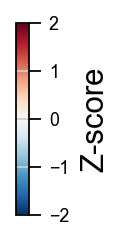

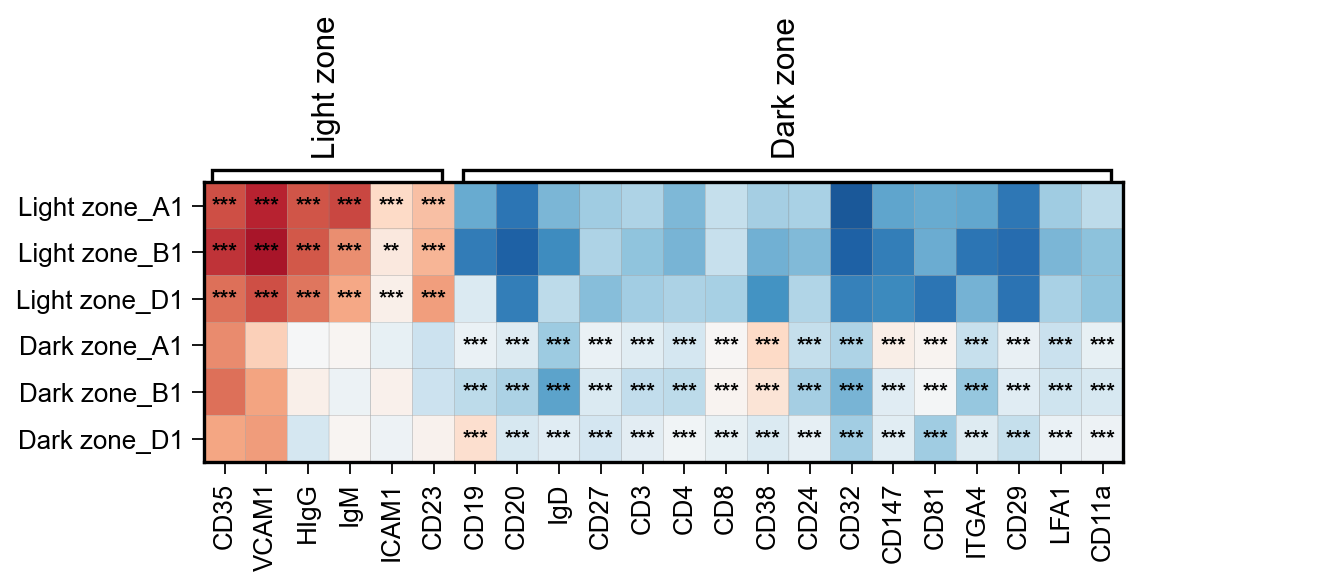

In [34]:
plot_matrixplot_horizontal_with_stars(
    adata_protein_gc_follicle, marker_proteins_dict, df_sig_filtered,
    figsize=(10, 2.3),
    save_path="figures/Fig-2-e.svg",
)
